## San Francisco Crime Classification 

목차:

**[I. 데이터 불러오기 및 확인](#one)**


**[II. EDA & FE](#two)**

- [a. concat](#two-a)
- [b. 타겟변수 확인](#two-b)
- [c. Dates](#two-c)
- [d. PdDistrict](#two-d)
- [e. DayOfWeek](#two-e)
- [f. Address](#two-f)
- [g. X,Y](#two-g)
    
**[III. 모델링](#three)**

- [a. lightgbm](#three-a)
- [b. xgboost](#three-b)
- [c. 앙상블](#three-c)

## I. 데이터 불러오기 및 확인 <a id="one"></a>

1. 변수 | 설명
------- | -------
**Dates ** | 범죄가 일어난 날
**Category ** | 범죄 유형 
**Descript ** | 범죄에 대한 자세한 설명 
**DayOfWeek ** | 요일  
**PdDistrict ** | 경찰 관할 지역 명칭 
**Resolution ** | 범죄 해결 여부 
**Address ** | 범죄 발생 주소 
**X ** | 경도(Longitude) 
**Y** | 위도(Latitude)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv("train.csv", parse_dates=['Dates'])
test = pd.read_csv("test.csv", parse_dates=['Dates'], index_col='Id')
sampleSubmission = pd.read_csv("sampleSubmission.csv")

In [4]:
train.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [5]:
test.head(3)

,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


> 결측치는 없는것으로 확인 되었습니다

### a.concat <a id="two-a"></a>

In [7]:
fe_name = list(test)
df_train = train[fe_name]
df = pd.concat((df_train,test))

### b.타겟변수 확인 <a id="two-b"></a>

In [8]:
target = train['Category']

In [9]:
target.value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [10]:
from sklearn.preprocessing import LabelEncoder

LB = LabelEncoder() 
target = LB.fit_transform(target)
print(LB.classes_)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']


In [11]:
target

array([37, 21, 21, ..., 16, 35, 12])

> 데이터 모델링을 위해서 타겟변수를 라벨인코더 해줍니다

### c.Dates <a id="two-c"></a>

In [12]:
date = pd.to_datetime(df['Dates'])
df['Date'] = date.dt.date
df['Year'] = date.dt.year
df['Month'] = date.dt.month
df['Day'] = date.dt.day
df['Hour'] = date.dt.hour

In [13]:
df.drop("Dates", axis = 1, inplace = True)

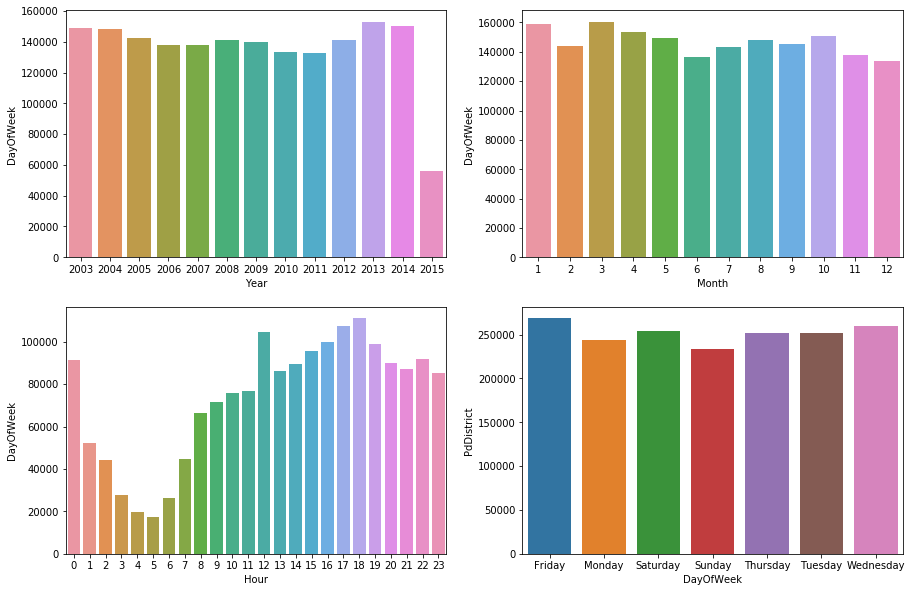

In [14]:
year = df.groupby('Year').count().iloc[:,0]
month = df.groupby('Month').count().iloc[:,0]
hour = df.groupby('Hour').count().iloc[:,0]
dayofweek = df.groupby('DayOfWeek').count().iloc[:, 0]

figure, axs = plt.subplots(2,2, figsize = (15,10))

sns.barplot(x=year.index, y= year,ax = axs[0][0])
sns.barplot(x=month.index, y= month,ax = axs[0][1])
sns.barplot(x=hour.index, y= hour,ax = axs[1][0])
sns.barplot(x=dayofweek.index, y= dayofweek,ax = axs[1][1])

>연도에 따른 범죄수 확인 결과  2015년에는 급격히 떨어진것을 확인해볼 수 있습니다.
>
>시간에 따른 범죄수 확인 결과 새벽시간에 제일 적었으며 12,18시가 가장 많은 것으로 보입니다.

In [15]:
date = df.groupby('Date').count().iloc[:, 0]

Text(389.0, 0.005, 'Median 389.0')

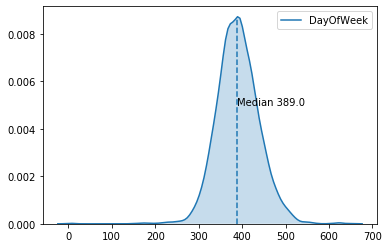

In [16]:
sns.kdeplot(data=date, shade=True)
plt.axvline(x=date.median(), ymax=0.95, linestyle='--')
plt.annotate('Median ' + str(date.median()),xy =(date.median(), 0.005))

> 하루 동안 발생하는 범죄수는 정규분포를 보이고 있으며 그 중앙값은 389입니다.

In [17]:
lb = LabelEncoder()
df['PdDistrict'] = lb.fit_transform(df["PdDistrict"])

### d.PdDistrict <a id="two-d"></a>

In [18]:
df["PdDistrict"].value_counts()

7    314638
3    240357
4    212313
0    179022
1    171590
9    163556
2    158929
8    132213
5     99512
6     90181
Name: PdDistrict, dtype: int64

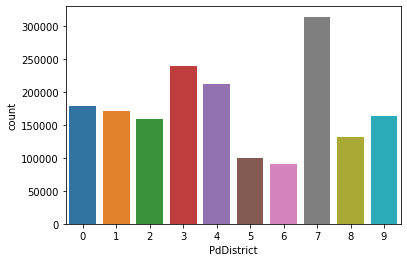

In [19]:
sns.countplot(df["PdDistrict"])

In [20]:
lb = LabelEncoder()
df['PdDistrict'] = lb.fit_transform(df["PdDistrict"])

> PdDistrict 피처에 대해서 라벨 인코더 해줍니다

In [21]:
### e.DayOfWeek <a id="two-e"></a>

In [22]:
df['DayOfWeek'] = lb.fit_transform(df["DayOfWeek"])

> DayOfWeek 피처에 대해서 라벨 인코더 해줍니다

### f.Address <a id="two-f"></a>

In [23]:
df["Address"].value_counts().head(20)

800 Block of BRYANT ST          53517
800 Block of MARKET ST          13464
2000 Block of MISSION ST        10052
1000 Block of POTRERO AV         8210
0 Block of TURK ST               6444
900 Block of MARKET ST           6256
0 Block of 6TH ST                5682
300 Block of ELLIS ST            5488
16TH ST / MISSION ST             5156
400 Block of ELLIS ST            5026
1000 Block of MARKET ST          4924
1100 Block of MARKET ST          4563
100 Block of OFARRELL ST         4464
2000 Block of MARKET ST          4433
700 Block of MARKET ST           4062
3200 Block of 20TH AV            4036
100 Block of 6TH ST              3858
500 Block of JOHNFKENNEDY DR     3728
0 Block of UNITEDNATIONS PZ      3650
0 Block of PHELAN AV             3509
Name: Address, dtype: int64

In [24]:
df['block'] = df['Address'].str.contains('block', case=False)
df['ST'] = df['Address'].str.contains('ST', case=False)

In [25]:
df['block'] = lb.fit_transform(df["block"])
df['ST'] = lb.fit_transform(df["ST"])

In [26]:
df.drop("Address", axis = 1, inplace = True)

> Address 피처에서 block과 ST 즉 구역과 거리를 포함하고 있는지 없는지를 구분해주는 새로운 파생변수를 만들어 줍니다

### g.X,Y <a id="two-g"></a>

In [27]:
print(df["X"].min(), df["X"].max())
print(df["Y"].min(), df["Y"].max())

-122.51364206429 -120.5
37.7078790224135 90.0


In [28]:
print(len(df.loc[df["X"] >= -120.5, "X"]))
print(len(df.loc[df["Y"] >= 90, "Y"]))

143
143


In [29]:
X_median = df[df["X"] < -120.5]["X"].median()
Y_median = df[df["Y"] < 90]["Y"].median()
df.loc[df["X"] >= -120.5, "X"] = X_median
df.loc[df["Y"] >= 90, "Y"] = Y_median

>143개의 X와 Y의 값이 잘못 표기되어 있는 것으로 보아 중앙값으로 대체해 줍니다.

In [30]:
df["X+Y"] = df["X"] + df["Y"]
df["X-Y"] = df["X"] - df["Y"]

In [31]:
df.drop("Date", axis = 1, inplace = True)

> 위도와 경도의 합과 차이를 구하는 새로운 파생 변수를 만들어 줍니다

## III. 모델링 <a id="three"></a>

In [32]:
new_train = df[:train.shape[0]]
new_test = df[train.shape[0]:]

In [33]:
new_train.head()

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,block,ST,X+Y,X-Y
0,6,4,-122.425892,37.774599,2015,5,13,23,0,1,-84.651293,-160.200490
1,6,4,-122.425892,37.774599,2015,5,13,23,0,1,-84.651293,-160.200490
2,6,4,-122.424363,37.800414,2015,5,13,23,0,1,-84.623949,-160.224777
3,6,4,-122.426995,37.800873,2015,5,13,23,1,1,-84.626123,-160.227868
4,6,5,-122.438738,37.771541,2015,5,13,23,1,1,-84.667196,-160.210279


### a. lightgbm <a id="three-a"></a>

In [34]:
import lightgbm as lgb

train_data = lgb.Dataset(new_train, label=target, categorical_feature=["PdDistrict", "DayOfWeek"])
params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':39,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41,
          'verbose' : 1}
bst = lgb.train(params, train_data, 120)

C:\Users\user\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [35]:
predictions = bst.predict(new_test)

In [36]:
submission = pd.DataFrame(predictions,columns=LB.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),index=new_test.index)
submission.to_csv('LGB.csv', index_label='Id')

> Yannis Pappas의 커널에서 LGBM 모델의 파라미터를 참고하였습니다. Bayesian Optimization을 통해서 하이퍼 파라미터 튜닝을 해줘야 하지만 추후에 하이퍼 파라미터 튜닝을 해줘야겠습니다.

### b. xgboost <a id="three-b"></a>

In [37]:
import xgboost as xgb
train_xgb = xgb.DMatrix(new_train, label=target)
test_xgb  = xgb.DMatrix(new_test)

In [38]:
params = {
    'max_depth': 4,  
    'eta': 0.3,  
    'silent': 1, 
    'objective': 'multi:softprob', 
    'num_class': 39,
}

xg = xgb.cv(params, train_xgb, nfold=3, early_stopping_rounds=10, metrics='mlogloss', verbose_eval=True) 

[0]	train-mlogloss:3.12872+0.000465844	test-mlogloss:3.12974+0.00103285
[1]	train-mlogloss:2.95217+0.00107542	test-mlogloss:2.95386+0.00210539
[2]	train-mlogloss:2.83356+0.00156834	test-mlogloss:2.83571+0.0025293
[3]	train-mlogloss:2.74836+0.00154846	test-mlogloss:2.75106+0.00252287
[4]	train-mlogloss:2.6854+0.00167586	test-mlogloss:2.68859+0.00257914
[5]	train-mlogloss:2.63612+0.00175285	test-mlogloss:2.63977+0.00258088
[6]	train-mlogloss:2.59705+0.00213026	test-mlogloss:2.60113+0.00285149
[7]	train-mlogloss:2.56538+0.00226838	test-mlogloss:2.57002+0.0027819
[8]	train-mlogloss:2.54007+0.00248213	test-mlogloss:2.54514+0.00301054
[9]	train-mlogloss:2.5183+0.00211744	test-mlogloss:2.52391+0.00265958


In [39]:
train_xgb = xgb.train(params, train_xgb, 10)
pred_xgb = train_xgb.predict(test_xgb)

In [40]:
submission1 = pd.DataFrame(pred_xgb,columns=LB.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),index=new_test.index)
submission1.to_csv('XGB.csv', index_label='Id')

### c. 앙상블 <a id="three-c"></a>

In [48]:
ensemble = 0.9*predictions + 0.1*pred_xgb

In [49]:
sub = pd.DataFrame(ensemble,columns=LB.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),index=new_test.index)
sub.to_csv('submission.csv', index_label='Id')